In [59]:
import torch
import torchvision


In [60]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


In [61]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [62]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [63]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [64]:
#train = enumerate(train_loader)
#batch_idx_train, (train_data, train_targets) = next(train)


#train_data_flat = torch.flatten(train_data)
#print(train_data_flat.shape[0])
#print(train_data.shape)

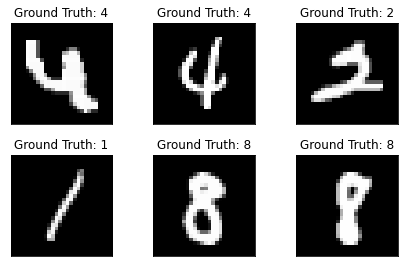

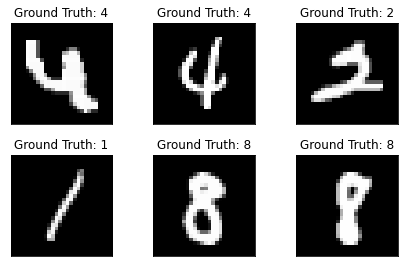

In [65]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [120]:
import torch.nn.functional as F
cuda0 = torch.device('cuda:0')
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return F.log_softmax(y_pred)

In [139]:
import torch.optim as optim
import torch.nn as nn
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 28*28, 100, 10

# Create random Tensors to hold inputs and outputs

# Construct our model by instantiating the class defined above
modelCuda = TwoLayerNet(D_in, H, D_out)
modelCuda.cuda()
optimizer = optim.SGD(modelCuda.parameters(), lr=learning_rate,
                      momentum=momentum)
def trainCuda(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = torch.reshape(data, (data.shape[0], D_in)).cuda()
    target = target.cuda()
    output = modelCuda(data).cuda()
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [140]:
def testCuda():
  modelCuda.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = torch.reshape(data, (data.shape[0], D_in)).cuda()
      target = target.cuda()
      data = data.cuda()
      output = modelCuda(data).cuda()
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [141]:
import time
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
start = time.time()
testCuda()
for epoch in range(1, n_epochs + 1):
  trainCuda(epoch)
  testCuda()
end = time.time()
print("Cudatime: " + str(end - start))


<ipython-input-120-733c2f99c62e>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y_pred)
C:\Users\jomer\anaconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

Test set: Avg. loss: 2.3085, Accuracy: 946/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302406
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.023767
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.775996
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.432889
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.210140
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.014699
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.945184
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.930426
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.834803
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.685132
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.742729
Train Epoch: 1 [7040

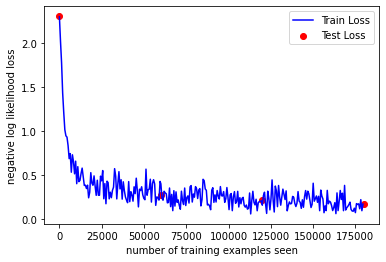

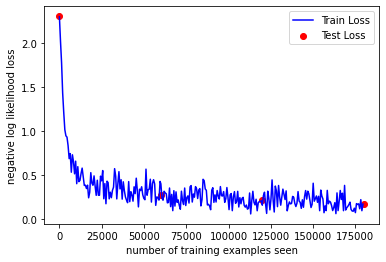

In [142]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [147]:
model = TwoLayerNet(D_in, H, D_out)
model
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = torch.reshape(data, (data.shape[0], D_in))
    target = target
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = torch.reshape(data, (data.shape[0], D_in))
      target = target
      data = data
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [148]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
start = time.time()
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
end = time.time()
print("Normal time: " + str(end - start))

<ipython-input-120-733c2f99c62e>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(y_pred)
C:\Users\jomer\anaconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

Test set: Avg. loss: 2.3369, Accuracy: 1212/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.369508
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.066971
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.755274
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.448787
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.280753
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.986094
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.882299
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.875317
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.647726
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.412556
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.657449
Train Epoch: 1 [70

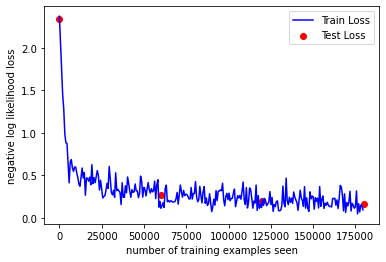

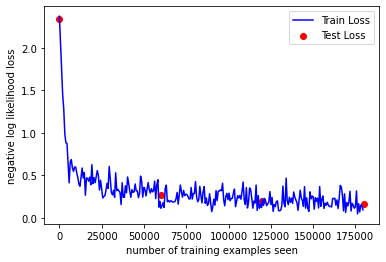

In [149]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig